# Whistle Detection with Continuous Kernel Convolutional Networks

In [1]:
from config import *
import os
import warnings
warnings.filterwarnings("ignore")

config_path = os.path.join("config","config.yaml")
config: Config = load_config(config_path)
torch_config: TorchConfig = config.torch
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
whistlenet_config: WhistlenetConfig = config.whistlenet

In [2]:
import torch
import numpy as np
torch.manual_seed(torch_config.seed)
np.random.seed(torch_config.seed)

## Dataset Preparation

In [3]:
from whistlenet.data import WhistleDataset
from whistlenet.core.utils import plot, NUM_FREQS
from whistlenet.core.utils.audio import SampleType

dataset = WhistleDataset(dataset_config)
dataset.summarize()
reshaped = dataset.train_data.reshape((dataset.train_data.data.shape[0], NUM_FREQS))
plot(reshaped, dataset.train_data.labels, SampleType)

LibsndfileError: Error opening '/home/neverorfrog/code/whistlenet/data/whistle/raw/train_cut/test_pc.wav': System error.

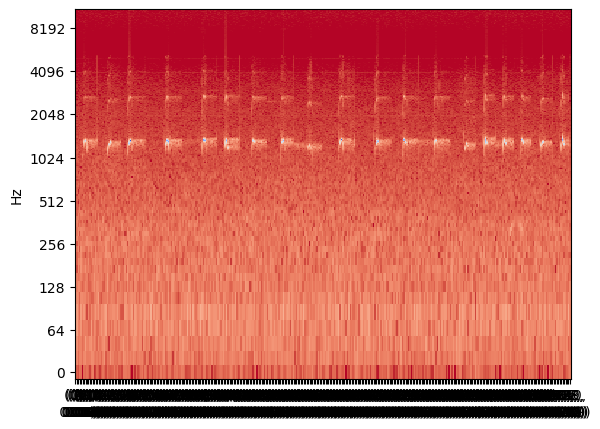

In [4]:
from whistlenet.core.utils import Audio, project_root
projroot = project_root()
audio = Audio(name="KronosTest_RC22", datapath=f'{projroot}/data/whistle/raw/train_cut', labelpath=f'{projroot}/data/whistle/labels/train_cut')
audio.freq_plot()

## Model 

In [5]:
from whistlenet.models import WhistleNet, Baseline

model = WhistleNet(in_channels=1, out_channels=1, config=whistlenet_config)
# model = Baseline(config=baseline_config)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 81875


## Trainer

In [6]:
from whistlenet.core import Trainer
from aim import Run

tracker = Run(experiment=model.name)
trainer = Trainer(trainer_config, tracker)
trainer.fit(model,dataset)
model.load()

Epoch 1, training:   0%|          | 1/1797 [00:00<17:55,  1.67it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


Epoch 1, training:   0%|          | 5/1797 [00:00<03:47,  7.87it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


Epoch 1, training:   1%|          | 10/1797 [00:01<02:15, 13.15it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


Epoch 1, training:   1%|          | 14/1797 [00:01<01:54, 15.55it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


Epoch 1, training:   1%|          | 18/1797 [00:01<01:43, 17.16it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


Epoch 1, training:   1%|          | 22/1797 [00:01<01:45, 16.79it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


Epoch 1, training:   1%|▏         | 26/1797 [00:01<01:39, 17.73it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


Epoch 1, training:   2%|▏         | 30/1797 [00:02<01:39, 17.70it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


Epoch 1, training:   2%|▏         | 34/1797 [00:02<01:35, 18.44it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


Epoch 1, training:   2%|▏         | 36/1797 [00:02<01:34, 18.71it/s]

## Inference on test audio

In [7]:
import torch
import time

audiolabels = audio.get_labels()

def normalize(data: torch.Tensor, epsilon: float = 1e-6) -> torch.Tensor:
    min = data.min()
    max = data.max()
    data = (data - min) / (
        max - min + epsilon
    )  # Adding epsilon to avoid division by zero
    return data

def classify(window):
    with torch.inference_mode():
        start = time.time()
        confidence = model(window).item()
        print(f"Confidence: {confidence:.4f}")
        prediction = 1 if confidence > 0.5 else 0
        elapsed = time.time() - start
        print(f"Prediction: {prediction}, elapsed: {elapsed:.4f}")
        return prediction

for i in range(audio.frames):
    window = torch.from_numpy(audio.S[0,:,i].reshape(1,1,NUM_FREQS))
    window = normalize(window)
    print(f"frame {i}, time {audio.frame2time(i):.2f}")
    print(f"label: {audiolabels[0,i]}")
    classify(window)
    print()

frame 0, time 0.00
label: 0.0
Confidence: 0.1256
Prediction: 0, elapsed: 0.0034

frame 1, time 0.02
label: 0.0
Confidence: 0.1243
Prediction: 0, elapsed: 0.0007

frame 2, time 0.05
label: 0.0
Confidence: 0.1200
Prediction: 0, elapsed: 0.0007

frame 3, time 0.07
label: 0.0
Confidence: 0.1166
Prediction: 0, elapsed: 0.0007

frame 4, time 0.09
label: 0.0
Confidence: 0.1234
Prediction: 0, elapsed: 0.0006

frame 5, time 0.12
label: 0.0
Confidence: 0.1058
Prediction: 0, elapsed: 0.0007

frame 6, time 0.14
label: 1.0
Confidence: 0.1237
Prediction: 0, elapsed: 0.0008

frame 7, time 0.16
label: 1.0
Confidence: 0.1373
Prediction: 0, elapsed: 0.0011

frame 8, time 0.19
label: 0.0
Confidence: 0.1169
Prediction: 0, elapsed: 0.0011

frame 9, time 0.21
label: 0.0
Confidence: 0.1047
Prediction: 0, elapsed: 0.0007

frame 10, time 0.23
label: 0.0
Confidence: 0.1230
Prediction: 0, elapsed: 0.0006

frame 11, time 0.26
label: 0.0
Confidence: 0.1261
Prediction: 0, elapsed: 0.0007

frame 12, time 0.28
label:

## Export to ONNX

In [8]:
file = f"{projroot}/models/{model.name}/whistle.onnx"

torch.onnx.export(
    model,
    model.example_input[0],
    f = file,
    input_names=["input"],
    output_names=["output"],
)

RuntimeError: Inference tensors cannot be saved for backward. To work around you can make a clone to get a normal tensor and use it in autograd.